<a href="https://colab.research.google.com/github/KonlavachMengsuwan/SAM-Hyperparameter-stability-score-thresh/blob/main/SAM_Hyperparameter_stability_score_thresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SamAutomaticMaskGenerator**

Source: https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

```
        model: Sam,
        points_per_side: Optional[int] = 32,
        points_per_batch: int = 64,
        pred_iou_thresh: float = 0.88,
        stability_score_thresh: float = 0.95,
        stability_score_offset: float = 1.0,
        box_nms_thresh: float = 0.7,
        crop_n_layers: int = 0,
        crop_nms_thresh: float = 0.7,
        crop_overlap_ratio: float = 512 / 1500,
        crop_n_points_downscale_factor: int = 1,
        point_grids: Optional[List[np.ndarray]] = None,
        min_mask_region_area: int = 0,
        output_mode: str = "binary_mask",
```




**Arguments:**

**model (Sam):** The SAM model to use for mask prediction.

**points_per_side (int or None):** The number of points to be sampled along one side of the image. The total number of points is points_per_side**2. If None, 'point_grids' must provide explicit point sampling.

**points_per_batch (int):** Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.

**pred_iou_thresh (float):** A filtering threshold in [0,1], using the model's predicted mask quality.

**stability_score_thresh (float):** A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.

**stability_score_offset (float):** The amount to shift the cutoff when calculated the stability score.

**box_nms_thresh (float):** The box IoU cutoff used by non-maximal suppression to filter duplicate masks.

**crop_n_layers (int):** If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.

**crop_nms_thresh (float):** The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.

**crop_overlap_ratio (float):** Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.

**crop_n_points_downscale_factor (int):** The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.

**point_grids (list(np.ndarray) or None):** A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.

**min_mask_region_area (int):** If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.

**output_mode (str):** The form masks are returned in. Can be 'binary_mask', 'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools. For large resolutions, 'binary_mask' may consume large amounts of memory.

In [1]:
# Install Library

## SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

## Others
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-zr35r_r0
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-zr35r_r0
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=7afadedcf4661bdef0f4db66a7c5684ae65c7561f62b8b24017be60061d48069
  Stored in directory: /tmp/pip-ephem-wheel-cache-eqjy41e6/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
cd

/root


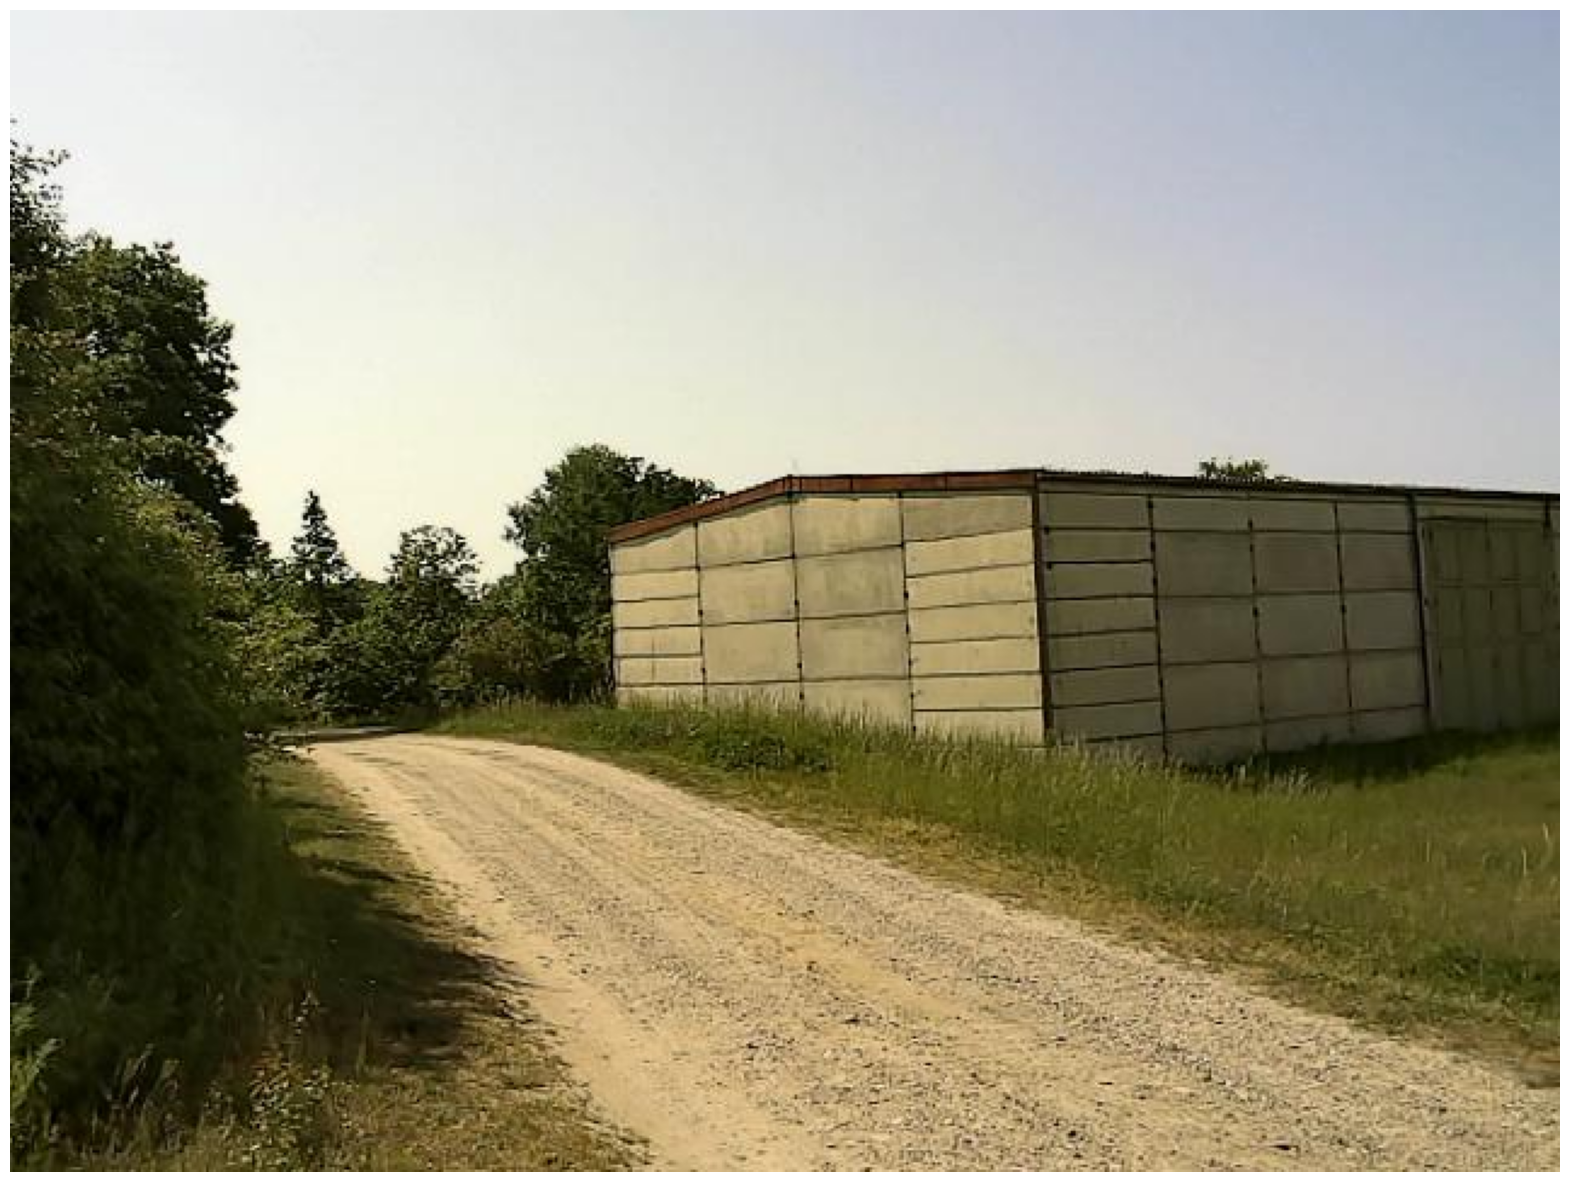

In [3]:
## Import OpenCV & numpy
## Read Sample Image

import cv2
import matplotlib.pyplot as plt
import numpy as np

#image_path = '1_Visual_Image.jpeg'
#image_path = 'HM20230526151007_IR.jpeg'
image_path = 'HM20230526142403_IR.jpeg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
# Import functions

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
# sam_checkpoint & model_type

## 1. "sam_vit_h_4b8939.pth" & "vit_h"

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-enzy6dgp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-enzy6dgp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-08-10 18:18:42--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  -

56


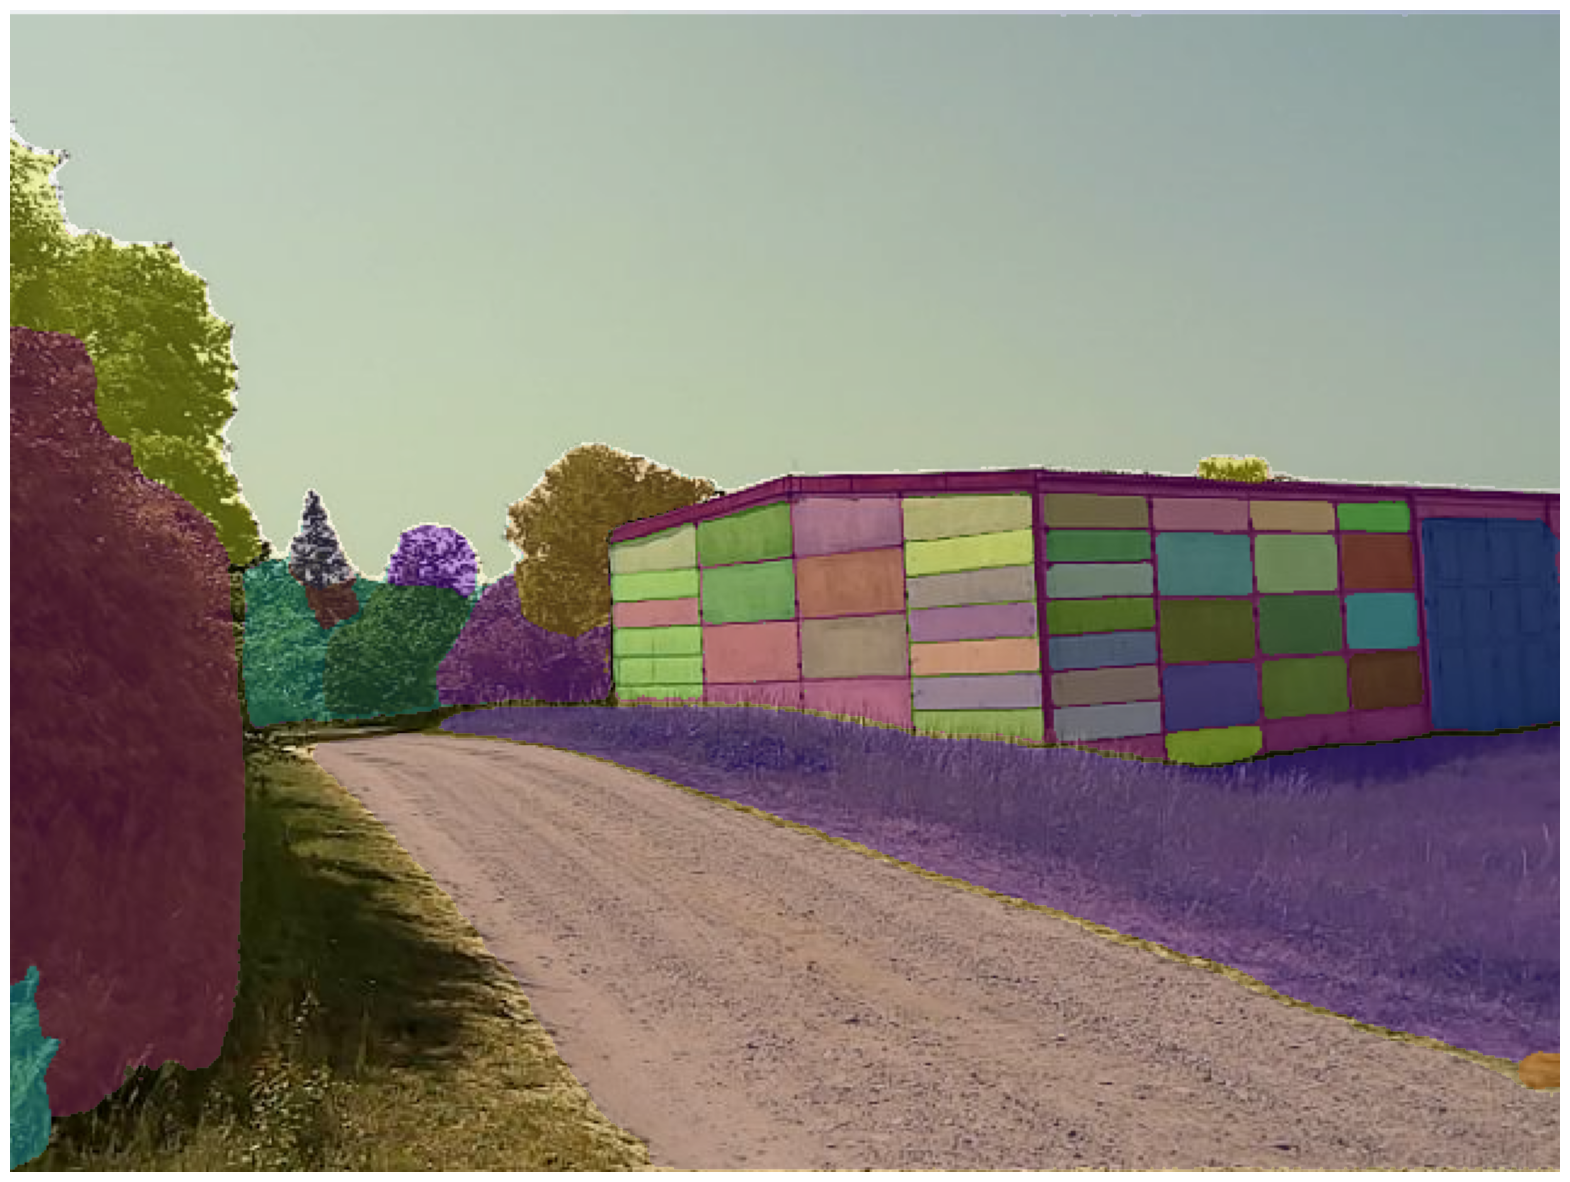

In [7]:
# SAM Default

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

print(len(masks))

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

Hyperparameter: stability_score_thresh

In [ ]:
# stability_score_thresh

# More Segmentation:
## Decrease pred_iou_thresh and stability_score_thresh to be less strict.
## Decrease box_nms_thresh and crop_nms_thresh to reduce suppression of similar masks.
## Increase points_per_side for finer granularity.

# stability_score_thresh
## stability_score_thresh: float = 0.75,
## stability_score_thresh: float = 0.50,
## stability_score_thresh: float = 0.25,


In [8]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [11]:
# stability_score_thresh

# stability_score_thresh = 0.75
mask_generator_1 = SamAutomaticMaskGenerator(
    model=sam,
    stability_score_thresh = 0.75,
)

# stability_score_thresh = 0.50
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    stability_score_thresh = 0.50,
)

# stability_score_thresh = 0.25
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    stability_score_thresh = 0.25,
)

71


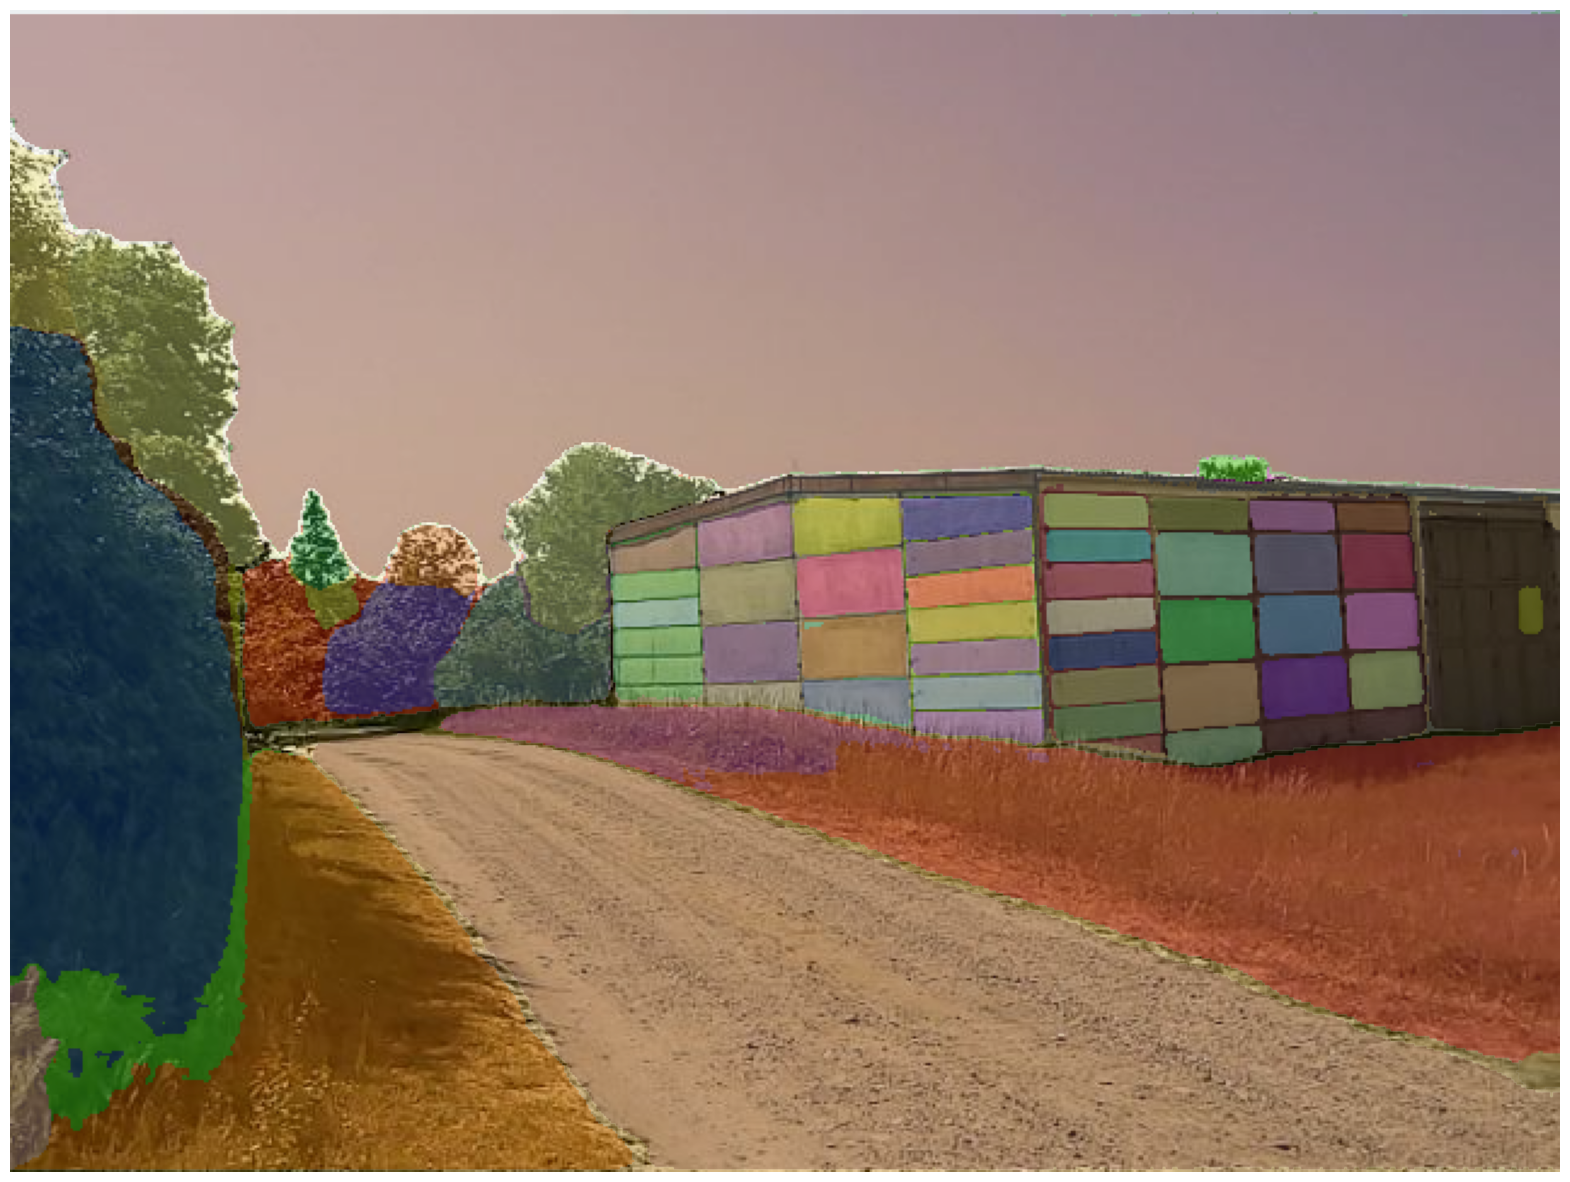

In [12]:
# stability_score_thresh = 0.75
masks_1 = mask_generator_1.generate(image)

print(len(masks_1))

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_1)
plt.axis('off')
plt.show()

74


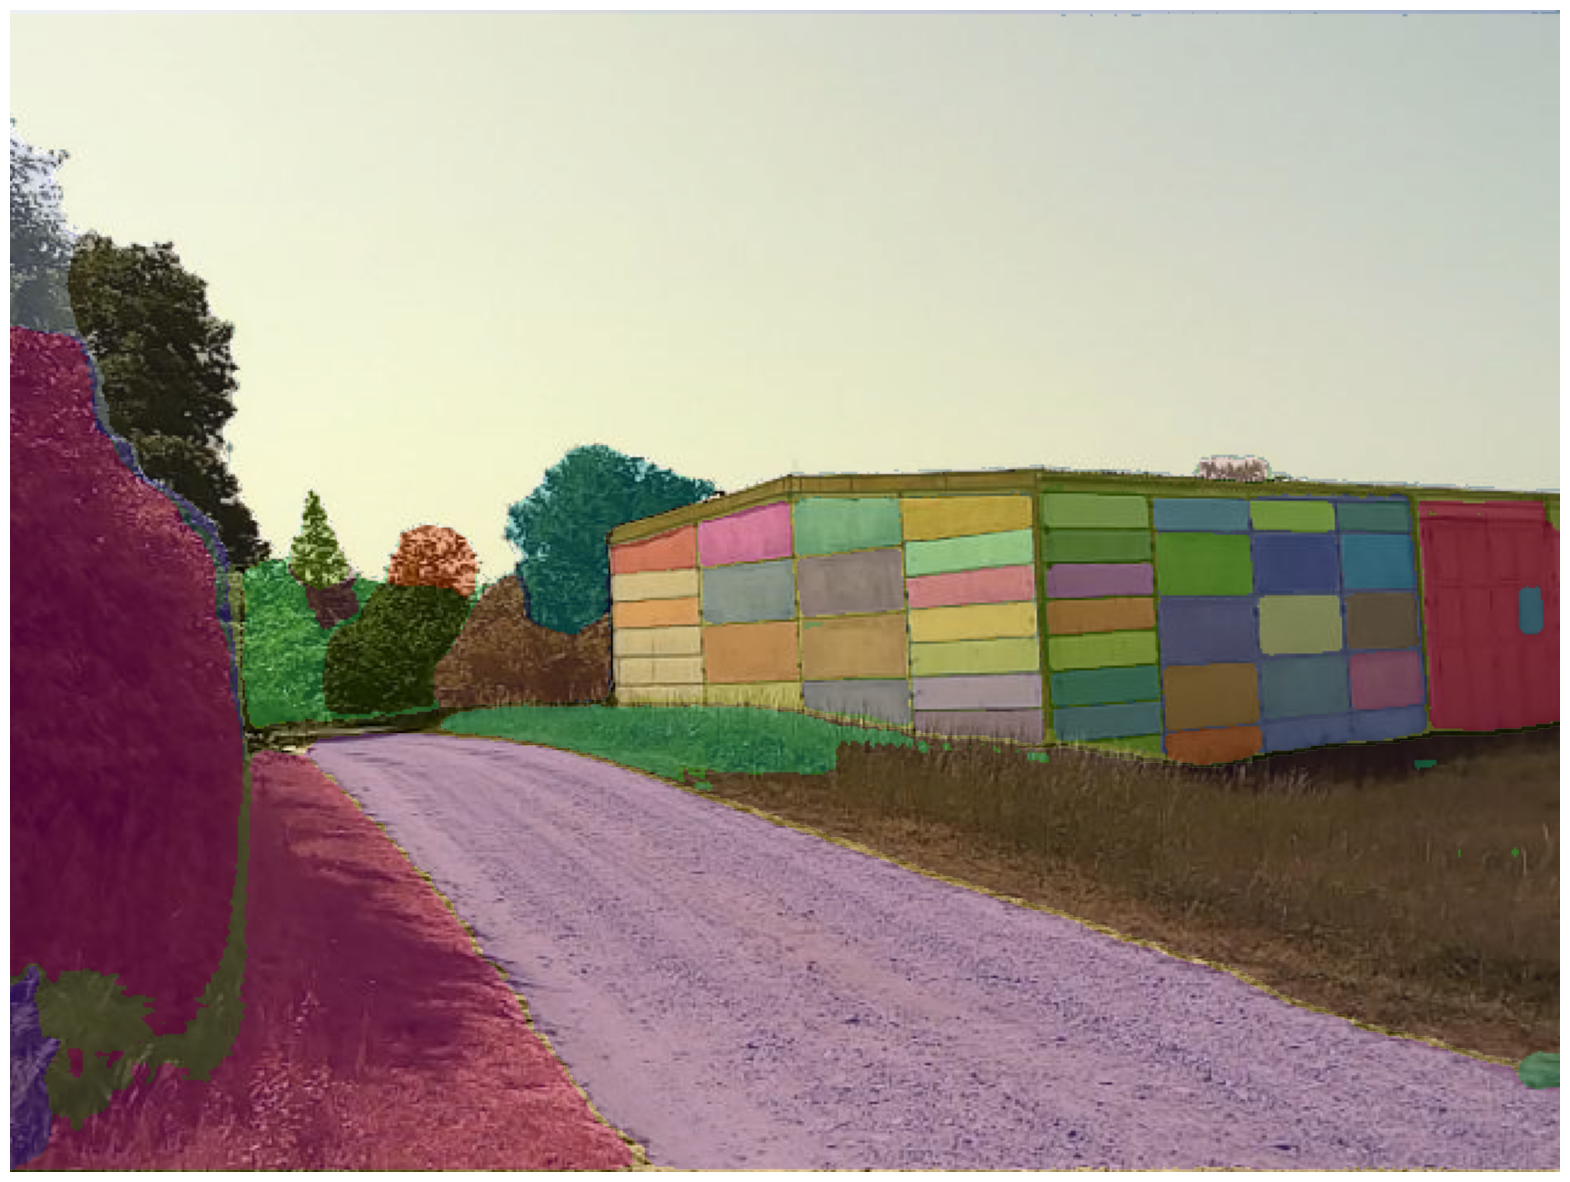

In [13]:
# stability_score_thresh = 0.50
masks_2 = mask_generator_2.generate(image)

print(len(masks_2))

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_2)
plt.axis('off')
plt.show()

74


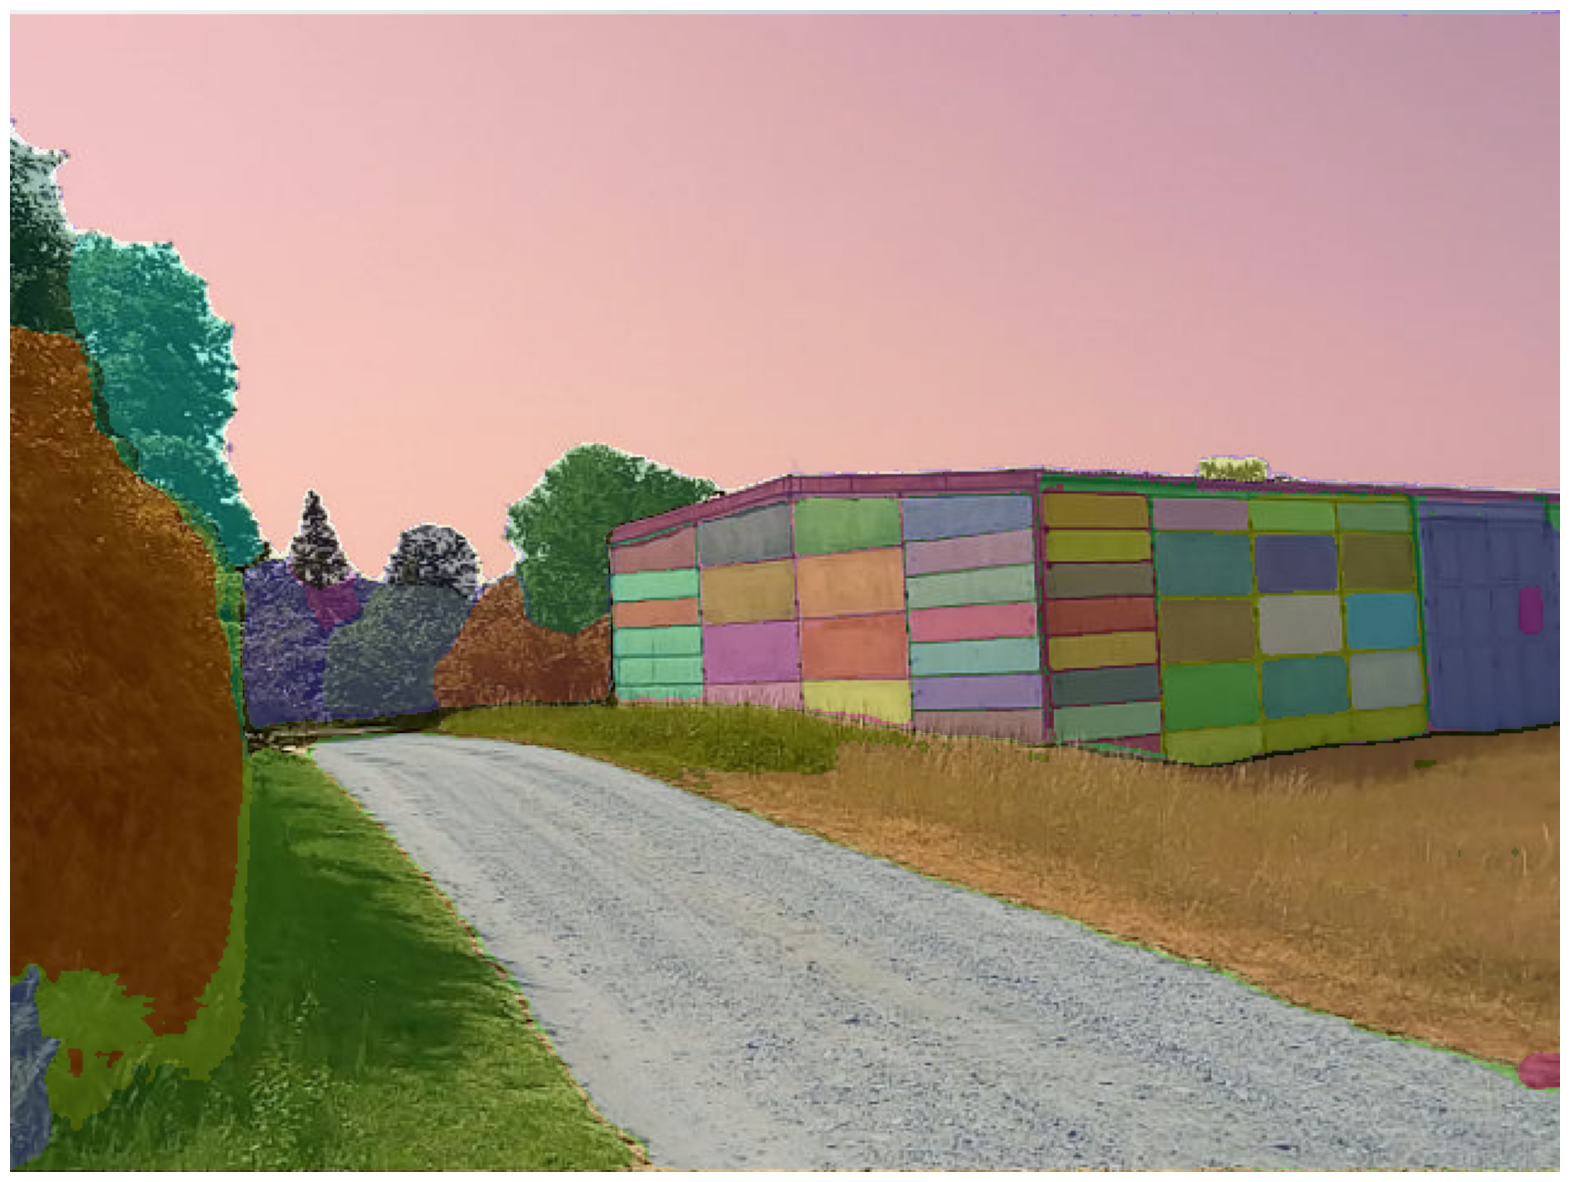

In [14]:
stability_score_thresh = 0.25
masks_3 = mask_generator_3.generate(image)

print(len(masks_3))

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_3)
plt.axis('off')
plt.show()